In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import tqdm.notebook
import os

import torchvision

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [3]:
class VariancePreservingSDE:
    
    def __init__(self, beta_0, beta_1, input_shape, seed=None):
        """
        Arguments:
            `beta_0`: beta(0); see below
            `beta_1`: beta(1); beta(t) will be linearly interpolated
                between beta(0) and beta(1)
            `input_shape`: a tuple of ints which is the shape of input
                tensors x; does not include batch dimension
            `seed`: random seed for sampling and running the SDE
        """
        self.input_shape = input_shape
        self.rng = torch.Generator(device=DEVICE)
        if seed:
            self.rng.manual_seed(seed)
        
        self.beta_0 = torch.tensor(beta_0).to(DEVICE)
        self.delta_beta = torch.tensor(beta_1 - beta_0).to(DEVICE)
        self.string = "Variance Preserving SDE (beta(t) = %.2f + %.2ft)" % (beta_0, beta_1 - beta_0)
        
        
    def _inflate_dims(self, v):
        """
        Given a tensor vector `v`, appends dimensions of size 1 so that
        it has the same number of dimensions as `self.input_shape`. For
        example, if `self.input_shape` is (3, 50, 50), then this function
        turns `v` from a B-tensor to a B x 1 x 1 x 1 tensor. This is
        useful for combining the tensor with things shaped like the input
        later.
        Arguments:
            `v`: a B-tensor
        Returns a B x `self.input_shape` tensor.
        """
        return v[(slice(None),) + ((None,) * len(self.input_shape))]
        
    
    def _beta(self, t):
        """
        Computes beta(t).
        Arguments:
            `t`: a B-tensor of times
        Returns a B-tensor of beta values.
        """
        return self.beta_0 + (self.delta_beta * t)
        
        
    def _beta_bar(self, t):
        """
        Computes the integral of beta(0) to beta(t).
        Arguments:
            `t`: a B-tensor of times
        Returns a B-tensor of beta-bar values.
        """
        return (self.beta_0 * t) + (0.5 * self.delta_beta * torch.square(t))
        
    
    def drift_coef_func(self, xt, t):
        """
        Definition of drift coefficient f(xt, t).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE for each input
        Returns a B x `self.input_shape` tensor.
        """
        return -0.5 * self._inflate_dims(self._beta(t)) * xt
    
    
    def diff_coef_func(self, xt, t):
        """
        Definition of diffusion coefficient g(t).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE
        Returns a B x `self.input_shape` tensor.
        """
        return self._inflate_dims(torch.sqrt(self._beta(t)))
    
    
    def forward(self, x0, t, return_score=True):
        """
        Runs the SDE forward given starting point `x0` and a time `t`.
        Optional returns the score: the gradient (with respect to x) of the
        log conditional probability, pt(xt | x0).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE for each input
        Returns a B x `self.input_shape` tensor to represent xt. If
        `return_score` is True, then also returns a B x `self.input_shape`
        tensor which is the gradient of the log conditional probability
        (with respect to `xt`).
        """
        z = torch.normal(
            torch.zeros_like(x0), torch.ones_like(x0), generator=self.rng
        )  # Shape: B x ...
        
        mean = x0 * torch.exp(-0.5 * self._inflate_dims(self._beta_bar(t)))
        variance = 1 - torch.exp(-self._beta_bar(t))
        std = self._inflate_dims(torch.sqrt(variance))  # Shape: B x ...
        
        xt = mean + (std * z)
        
        if return_score:
            score = -z / std
            return xt, score
        else:
            return xt
        

    def mean_score_mag(self, t):
        """
        Returns the average magnitude (squared L2 norm) of the score
        (averaged over sampling and data distribution), divided by the
        size of `x`. That is, this should be ||score||_2^2 / d, where d
        is the size of `x`.
        Arguments:
            `t`: a B-tensor containing the time in the SDE
        Returns a B-tensor containing the expected magnitude of the score
        function at each time `t`.
        """
        variance = 1 - torch.exp(-self._beta_bar(t))
        return 1 / variance  # Shape: B
        
        
    def sample_prior(self, num_samples, t):
        """
        Samples from the prior distribution specified by the SDE at time `t`.
        Arguments:
            `num_samples`: B, the number of samples to return
            `t`: a B-tensor containing the times in the SDE to sample for
        Returns a B x `self.input_shape` tensor for the `xt` values that
        are sampled.
        """
        # We will sample in the limit as t approaches infinity
        shape = torch.Size([num_samples]) + torch.Size(self.input_shape)
        return torch.normal(
            torch.zeros(shape).to(DEVICE), torch.ones(shape).to(DEVICE), generator=self.rng
        )  # Shape: B x ...
    
    
    def __str__(self):
        return self.string

### Define the score model $s_{\theta}$

We will start by defining it for image data, using a U-net architecture.

In [4]:
class ScoreUNet(torch.nn.Module):

    def __init__(
        self, t_limit=1, channels=[32, 64, 128, 256], time_embed_size=256, mean_score_mag=None,
        data_channels=1
    ):
        """
        Initialize a time-dependent score-based U-net.
        Arguments:
            `t_limit`: maximum time horizon
            `channels`: the number of channels in each "layer" of the U-net
            `time_embed_size`: size of the time embeddings
            `mean_score_mag`: if given, rescales the model outputs by multiplying
                by the average score magnitude (L2 norm); this must be a function
                which takes in a B-tensor of time points, and returns a B-tensor
                of expected squared L2 norms
            `data_channels`: number of channels in input image
        Note this architecture assumes the initial depth of the images is 1.
        """
        super().__init__()
        
        self.t_limit = t_limit
        self.mean_score_mag = mean_score_mag
        
        # Random embedding layer for time; the random weights are set at the
        # start and are not trainable
        self.time_embed_rand_weights = torch.nn.Parameter(
            torch.randn(time_embed_size // 2) * 30, requires_grad=False
        )
        self.time_embed_dense = torch.nn.Linear(time_embed_size, time_embed_size)
        
        # Encoders: receptive field increases and depth increases
        self.conv_e1 = torch.nn.Conv2d(data_channels, channels[0], kernel_size=3, stride=1, bias=False)
        self.time_dense_e1 = torch.nn.Linear(time_embed_size, channels[0])
        self.norm_e1 = torch.nn.GroupNorm(4, num_channels=channels[0])
        
        self.conv_e2 = torch.nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, bias=False)
        self.time_dense_e2 = torch.nn.Linear(time_embed_size, channels[1])
        self.norm_e2 = torch.nn.GroupNorm(32, num_channels=channels[1])
        
        self.conv_e3 = torch.nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=2, bias=False)
        self.time_dense_e3 = torch.nn.Linear(time_embed_size, channels[2])
        self.norm_e3 = torch.nn.GroupNorm(32, num_channels=channels[2])
        
        self.conv_e4 = torch.nn.Conv2d(channels[2], channels[3], kernel_size=3, stride=2, bias=False)
        self.time_dense_e4 = torch.nn.Linear(time_embed_size, channels[3])
        self.norm_e4 = torch.nn.GroupNorm(32, num_channels=channels[3])   

        # Decoders: depth decreases
        self.conv_d4 = torch.nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.time_dense_d4 = torch.nn.Linear(time_embed_size, channels[2])
        self.norm_d4 = torch.nn.GroupNorm(32, num_channels=channels[2])
        
        self.conv_d3 = torch.nn.ConvTranspose2d(channels[2] * 2, channels[1], 3, stride=2, output_padding=1, bias=False)
        self.time_dense_d3 = torch.nn.Linear(time_embed_size, channels[1])
        self.norm_d3 = torch.nn.GroupNorm(32, num_channels=channels[1])
        
        self.conv_d2 = torch.nn.ConvTranspose2d(channels[1] * 2, channels[0], 3, stride=2, output_padding=1, bias=False)
        self.time_dense_d2 = torch.nn.Linear(time_embed_size, channels[0])
        self.norm_d2 = torch.nn.GroupNorm(32, num_channels=channels[0])
        
        self.conv_d1 = torch.nn.ConvTranspose2d(channels[0] * 2, data_channels, 3, stride=1, bias=True)

        # Activation functions
        self.swish = lambda x: x * torch.sigmoid(x)  # Swish activation: x * sigmoid(x)

        
    def forward(self, xt, t):
        """
        Forward pass of the network.
        Arguments:
            `xt`: B x 1 x H x W tensor containing the images to train on
            `t`: B-tensor containing the times to train the network for each
                image
        Returns a B x 1 x H x W tensor which consists of the (unnormalized)
        score estimate.
        """
        # Get the time embeddings for `t`
        # We first sample vector z from some zero-mean Gaussian (of fixed variance),
        # and then we embed the time as cos(2 * pi * t * z) and sin(2 * pi * t * z)
        time_embed_args = t[:, None] * self.time_embed_rand_weights[None, :] * 2 * np.pi / t_limit
        # Shape: B x (E / 2)
        time_embed = self.swish(
            torch.cat([torch.sin(time_embed_args), torch.cos(time_embed_args)], dim=1)
        )
        # Shape: B x E
        
        # Encoding
        enc_1_out = self.swish(self.norm_e1(
            self.conv_e1(xt) + self.time_dense_e1(time_embed)[:, :, None, None]
        ))
        enc_2_out = self.swish(self.norm_e2(
            self.conv_e2(enc_1_out) + self.time_dense_e2(time_embed)[:, :, None, None]
        ))
        enc_3_out = self.swish(self.norm_e3(
            self.conv_e3(enc_2_out) + self.time_dense_e3(time_embed)[:, :, None, None]
        ))
        enc_4_out = self.swish(self.norm_e4(
            self.conv_e4(enc_3_out) + self.time_dense_e4(time_embed)[:, :, None, None]
        ))
            
        # Decoding
        dec_4_out = self.swish(self.norm_d4(
            self.conv_d4(enc_4_out) + self.time_dense_d4(time_embed)[:, :, None, None]
        ))
        dec_3_out = self.swish(self.norm_d3(
            self.conv_d3(torch.cat([dec_4_out, enc_3_out], dim=1)) + self.time_dense_d3(time_embed)[:, :, None, None]
        ))
        dec_2_out = self.swish(self.norm_d2(
            self.conv_d2(torch.cat([dec_3_out, enc_2_out], dim=1)) + self.time_dense_d2(time_embed)[:, :, None, None]
        ))
        dec_1_out = self.conv_d1(torch.cat([dec_2_out, enc_1_out], dim=1))
        
        if self.mean_score_mag:
            pred = dec_1_out * torch.sqrt(self.mean_score_mag(t)[:, None, None, None])
        else:
            pred = dec_1_out
        
        return pred

    
class MultitaskScoreUNet(torch.nn.Module):
    def __init__(
        self, num_branches, **kwargs
    ):
        """
        Initialize a multi-task time-dependent score-based U-net.
        Arguments:
            `num_branches`: number of branches to create in the score
                model; this is the number of independent parameter sets
                created
            `kwargs`: keyword arguments passed directly to ScoreUNet
        """
        super().__init__()
        
        self.branch_models = torch.nn.ModuleList([
            ScoreUNet(**kwargs) for _ in range(num_branches)
        ])
        
    
    def forward(self, xt, t, branch_index):
        """
        Forward pass of the network.
        Arguments:
            `xt`: B x 1 x H x W tensor containing the images to train on
            `t`: B-tensor containing the times to train the network for each
                image
            `branch_index`: scalar index of which branch to train
        Returns a B x 1 x H x W tensor which consists of the (unnormalized)
        score estimate.
        """
        return self.branch_models[branch_index](xt, t)

### Define the dataloader

In [5]:
import codecs, sys
def get_int(b: bytes) -> int:
    return int(codecs.encode(b, "hex"), 16)


SN3_PASCALVINCENT_TYPEMAP = {
    8: torch.uint8,
    9: torch.int8,
    11: torch.int16,
    12: torch.int32,
    13: torch.float32,
    14: torch.float64,
}


def read_sn3_pascalvincent_tensor(path: str, strict: bool = True) -> torch.Tensor:
    """Read a SN3 file in "Pascal Vincent" format (Lush file 'libidx/idx-io.lsh').
    Argument may be a filename, compressed filename, or file object.
    """
    # read
    with open(path, "rb") as f:
        data = f.read()
    # parse
    magic = get_int(data[0:4])
    nd = magic % 256
    ty = magic // 256
    assert 1 <= nd <= 3
    assert 8 <= ty <= 14
    torch_type = SN3_PASCALVINCENT_TYPEMAP[ty]
    s = [get_int(data[4 * (i + 1) : 4 * (i + 2)]) for i in range(nd)]

    num_bytes_per_value = torch.iinfo(torch_type).bits // 8
    # The MNIST format uses the big endian byte order. If the system uses little endian byte order by default,
    # we need to reverse the bytes before we can read them with torch.frombuffer().
    needs_byte_reversal = sys.byteorder == "little" and num_bytes_per_value > 1
    parsed = torch.frombuffer(bytearray(data), dtype=torch_type, offset=(4 * (nd + 1)))
    if needs_byte_reversal:
        parsed = parsed.flip(0)

    assert parsed.shape[0] == np.prod(s) or not strict
    return parsed.view(*s)


def read_label_file(path: str) -> torch.Tensor:
    x = read_sn3_pascalvincent_tensor(path, strict=False)
    if x.dtype != torch.uint8:
        raise TypeError(f"x should be of dtype torch.uint8 instead of {x.dtype}")
    if x.ndimension() != 1:
        raise ValueError(f"x should have 1 dimension instead of {x.ndimension()}")
    return x.long()


def read_image_file(path: str) -> torch.Tensor:
    x = read_sn3_pascalvincent_tensor(path, strict=False)
    if x.dtype != torch.uint8:
        raise TypeError(f"x should be of dtype torch.uint8 instead of {x.dtype}")
    if x.ndimension() != 3:
        raise ValueError(f"x should have 3 dimension instead of {x.ndimension()}")
    return x


class BranchedMNISTDataset(torch.utils.data.IterableDataset):
    def __init__(self, classes, branch_defs, data_path, batch_size=32):
        """
        Creates a dataset which yields batches of digits of certain
        subsets, time intervals, and branch indices.
        Arguments:
            `classes`: digit classes to include; a list of integers
            `branch_defs`: definitions of branches in the tree of
                classes; a list of pairs, where each pair is a
                branch of the form:
                ((tuple of classes), start time, end time)
            `data_path`: path to downloaded data
            `batch_size`: number of things to return per batch, B
        """
        self.branch_defs = branch_defs
        self.batch_size = batch_size
        
        # Import all images and labels
        all_images = read_image_file(os.path.join(data_path, "train-images-idx3-ubyte")).numpy()
        all_labels = read_label_file(os.path.join(data_path, "train-labels-idx1-ubyte")).numpy()
        
        # Create dictionary mapping each class to its images
        self.images_by_class = {}
        for c in classes:
            mask = all_labels == c
            self.images_by_class[c] = all_images[mask]
            
        # Precompute the branch index for each batch, based on the total number
        # of batches and the relative branch lengths
        total_branch_length = sum(bd[2] - bd[1] for bd in branch_defs)
        batch_total = int(np.ceil(len(all_images) / batch_size))
        branch_indices = []
        for i, bd in enumerate(branch_defs):
            branch_indices.extend([i] * max(1, int((bd[2] - bd[1]) / total_branch_length * batch_total)))
        self.branch_indices = np.array(branch_indices)
        self.num_batches = len(branch_indices)
            
    def get_batch(self, i):
        """
        Returns a batch of data. Batch generation will loop through the branch
        indices (which are a weighted sampling of the branches), and draw random
        images from the corresponding classes.
        Returns a B x 1 x 28 x 28 array of images, a B-array of labels, a
        branch index, a start time, and an end time.
        """
        branch_index = self.branch_indices[i]
        classes, t_start, t_end = self.branch_defs[branch_index]
        num_classes = len(classes)
        shard_size = int(np.ceil(self.batch_size / num_classes))
        
        images, labels = [], []
        for i in range(num_classes):
            num_to_pick = min(shard_size, self.batch_size - (i * shard_size))
            class_images = self.images_by_class[classes[i]]
            inds = np.random.choice(len(class_images), size=num_to_pick, replace=False)
            images.append(class_images[inds])
            labels.append(np.tile(classes[i], num_to_pick))
        
        images = np.concatenate(images)
        images = (images / 256 * 2) - 1
        images = np.expand_dims(images, axis=1)  # Go from B x 28 x 28 to B x 1 x 28 x 28
        return images, np.concatenate(labels), branch_index, t_start, t_end
    
    def __iter__(self):
        """
        Returns an iterator over the batches. If the dataset iterator is called
        from multiple workers, each worker will be give a shard of the full
        range.
        """
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:
            # In single-processing mode
            start, end = 0, self.num_batches
        else:
            worker_id = worker_info.id
            num_workers = worker_info.num_workers
            shard_size = int(np.ceil(self.num_batches / num_workers))
            start = shard_size * worker_id
            end = min(start + shard_size, self.num_batches)
        return (self.get_batch(i) for i in range(start, end))

    def __len__(self):
        return self.num_batches
    
    def on_epoch_start(self):
        np.random.shuffle(self.branch_indices)

In [6]:
def class_and_time_to_branch_index(c, t, branch_defs):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    # This is currently rather inefficient
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i

### Create the data loader

In [7]:
classes = [0, 4, 9]
branch_defs = [
    ((0, 4, 9), 0.5, 1),
    ((0,), 0, 0.5),
    ((4, 9), 0.3, 0.5),
    ((4,), 0, 0.3),
    ((9,), 0, 0.3)
]

# classes = [0]
# branch_defs = [
#     ((0,), 0, 1)
# ]

dataset = BranchedMNISTDataset(
    classes, branch_defs, "/gstore/data/resbioai/tsenga5/MNIST/raw"
)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=None, num_workers=2, collate_fn=lambda x: x)
data_loader.dataset.on_epoch_start()

input_shape = next(iter(data_loader))[0].shape[1:]
data_channels = input_shape[0]

### Train the model

In [8]:
def train_model(
    model, sde, data_loader, num_epochs, learning_rate,
    loss_weighting_type="norm", t_limit=1
):
    """
    Trains a diffusion model using the given instantiated model and SDE
    object.
    Arguments:
        `model`: an instantiated score model which takes in x, t and
            predicts score
        `sde`: an SDE object
        `data_loader`: a DataLoader object that yields batches of data
            in pairs: x, y (the y is not used)
        `num_epochs`: number of epochs to train for
        `learning_rate`: learning rate to use for training
        `loss_weighting_type`: method for weighting the loss; can be
            "ml" to weight by g^2, "norm" to weight by the mean
            magnitude of the loss, or None to do no weighting at all
        `t_limit`: training will occur between time 0 and `t_limit`
    """
    torch.set_grad_enabled(True)
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch_num in range(num_epochs):
        total_loss, total_inputs = 0, 0
        data_loader.dataset.on_epoch_start()
        t_iter = tqdm.notebook.tqdm(data_loader)
        for x0, classes, branch_index, t_start, t_end in t_iter:
            x0 = torch.tensor(x0).float().to(DEVICE)
            
            # Sample random times from t_start to t_end
            t = (torch.rand(x0.shape[0], device=DEVICE) * (t_end - t_start)) + t_start
            
            # Run SDE forward to get xt and the true score at xt
            xt, true_score = sde.forward(x0, t)
                        
            # Get model-predicted score
            pred_score = model(xt, t, branch_index)
                        
            # Get weighting factor
            if loss_weighting_type == "ml":
                loss_weight = 1 / sde.diff_coef_func(xt, t)
            elif loss_weighting_type == "norm":
                try:
                    loss_weight = sde._inflate_dims(sde.mean_score_mag(t))
                    raise NotImplementedError
                except NotImplementedError:
                    loss_weight = sde._inflate_dims(
                        torch.mean(torch.square(true_score), dim=tuple(range(1, len(x0.shape))))
                    )
            elif loss_weighting_type is None:
                loss_weight = torch.ones_like(x0)
            
            # Compute loss as MSE
            squared_error = torch.square(true_score - pred_score)
            loss = torch.mean(torch.sum(
                squared_error / loss_weight,
                dim=tuple(range(1, len(x0.shape)))
            ))
            
            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optim.step()
            loss_val = loss.item()
            if np.isnan(loss_val):
                continue
            total_loss += loss_val * x0.shape[0]
            total_inputs += x0.shape[0]
            
            t_iter.set_description("Loss: %.2f" % loss_val)
        
        print("Epoch %d average Loss: %.2f" % (epoch_num + 1, total_loss / total_inputs))
        torch.save(model.state_dict(), "ckpt.pth")

In [9]:
# Create the SDE and model
sde = VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1
model = MultitaskScoreUNet(
    num_branches=len(branch_defs), t_limit=t_limit, mean_score_mag=None, data_channels=data_channels
).to(DEVICE)

In [10]:
def plot_digits(x, num_to_plot=10, title=None):
    fig, ax = plt.subplots(ncols=num_to_plot, figsize=(20, 4))
    for i in range(num_to_plot):
        ax[i].imshow(np.transpose(x[i], axes=(1, 2, 0)), cmap="gray")
        ax[i].axis('off')
    if title:
        ax[0].set_title(title)
    plt.show()

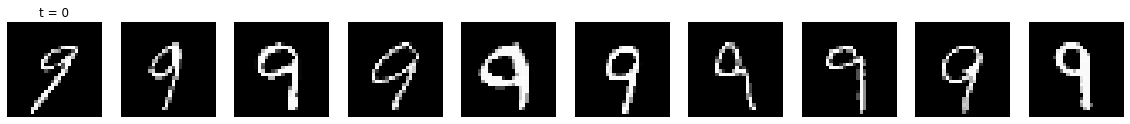

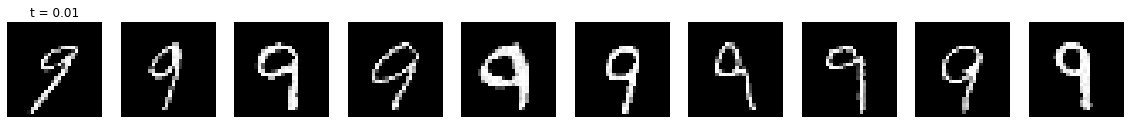

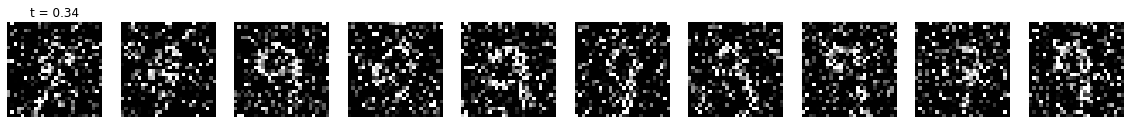

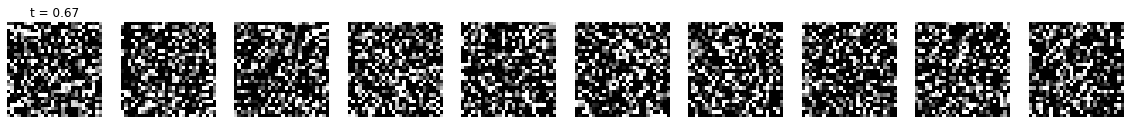

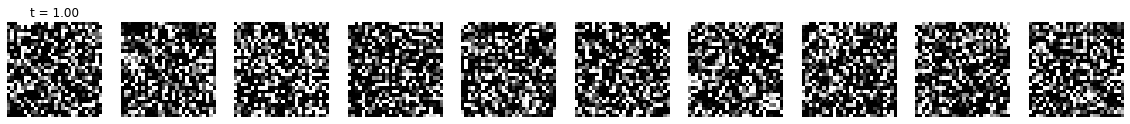

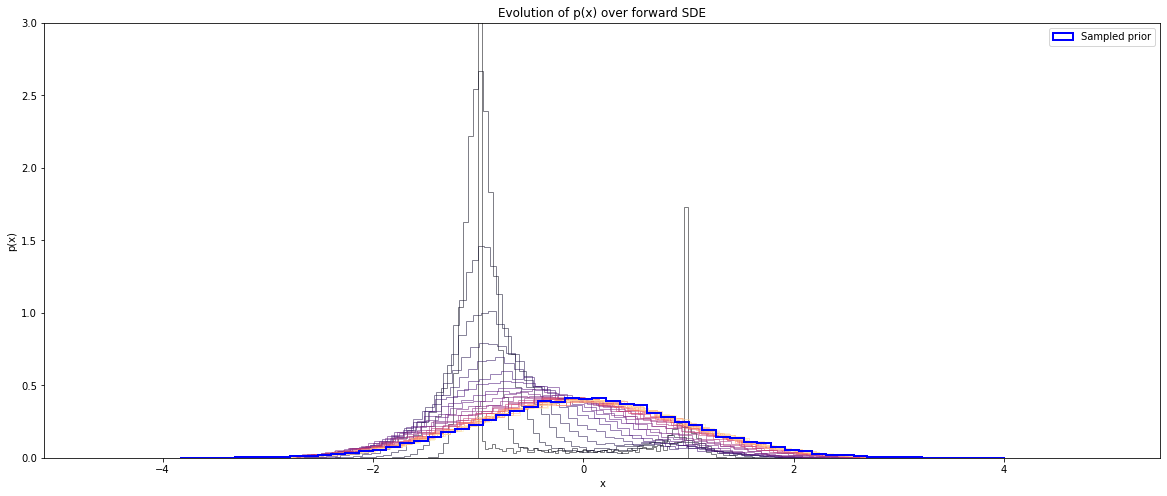

In [11]:
# Show some images after running the SDE forward for different times
time_steps = 4

x0, _, _, _, _ = next(iter(data_loader))
    
plot_digits(np.clip(x0, 0, 1), title="t = 0")
x0 = torch.tensor(x0).to(DEVICE)
for t in np.linspace(0.01, t_limit, time_steps):
    xt, score = sde.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    plot_digits(torch.clamp(xt, 0, 1).cpu().numpy(), title=("t = %.2f" % t))
    
# Show the transformation of the distribution of data to the prior distribution
time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

In [12]:
saved_vals = []
train_model(
    model, sde, data_loader, num_epochs=10, learning_rate=0.001,
    loss_weighting_type="norm", t_limit=t_limit
)

  0%|          | 0/1872 [00:00<?, ?it/s]

Epoch 1 average Loss: 243.65


  0%|          | 0/1872 [00:00<?, ?it/s]

Epoch 2 average Loss: 100.47


  0%|          | 0/1872 [00:00<?, ?it/s]

Epoch 3 average Loss: 88.15


  0%|          | 0/1872 [00:00<?, ?it/s]

Epoch 4 average Loss: 81.10


  0%|          | 0/1872 [00:00<?, ?it/s]

Epoch 5 average Loss: 74.03


  0%|          | 0/1872 [00:00<?, ?it/s]

Epoch 6 average Loss: 70.89


  0%|          | 0/1872 [00:00<?, ?it/s]

Epoch 7 average Loss: 67.53


  0%|          | 0/1872 [00:00<?, ?it/s]

Epoch 8 average Loss: 64.70


  0%|          | 0/1872 [00:00<?, ?it/s]

Epoch 9 average Loss: 63.76


  0%|          | 0/1872 [00:00<?, ?it/s]

Epoch 10 average Loss: 60.20


### Sample from the trained model

The three strategies for sampling from the trained model are:

1. Euler-Maruyama: We take the corresponding reverse SDE and step through it backwards through time
2. Predictor-Corrector: Like Euler-Maruyama, but in each step we also run a round of Langevin dynamics to better align the step with the score function
3. ODE: We take the corresponding ODE of the reverse SDE (which has the same transitional probabilities) and step through it backwards through time using an ODE solver

In [13]:
def generate_samples(
    model, sde, class_to_sample, sampler="em", num_samples=64, num_steps=500, epsilon=0.001,
    t_limit=1
):
    """
    Generates samples from a trained score model and SDE. This first
    generates a sample from the SDE's prior distribution a t = 1, then
    steps backward through time to generate new data points.
    Arguments:
        `model`: a trained score model which takes in x, t and
            predicts score
        `sde`: an SDE object
        `class_to_sample`: the class to sample from
        `sampler`: one of "em", "pc", or "ode" for Euler-Maruyama,
            predictor-corrector, or ordinary differential equation,
            respectively
        `num_samples`: number of objects to return
        `num_steps`: number of steps to take for Euler-Maruyama and
            predictor-corrector algorithms
        `epsilon`: last time step to stop at before hitting 0
        `t_limit`: the time step to start generating at
    Returns a tensor of size `num_samples` x ...
    """
    # First, sample from the prior distribution at some late time t
    t = torch.tensor(np.tile(t_limit, num_samples)).to(DEVICE)
    xt = sde.sample_prior(num_samples, t)
    
    # Disable gradient computation in model
    torch.set_grad_enabled(False)
    
    if sampler == "em":
        # Euler-Maruyama
        time_steps = torch.linspace(t_limit, epsilon, num_steps).to(DEVICE)  # Descending order
        step_size = time_steps[0] - time_steps[1]
        
        # Step backward through time starting at xt, simulating the reverse SDE
        x = xt
        for time_step in tqdm.notebook.tqdm(time_steps):
            branch_index = class_and_time_to_branch_index(class_to_sample, time_step, branch_defs)
            t = torch.ones(num_samples).to(DEVICE) * time_step
            f = sde.drift_coef_func(x, t)
            g = sde.diff_coef_func(x, t)
            dw = torch.randn_like(x)
            
            drift = (f - (torch.square(g) * model(x, t, branch_index))) * step_size
            diff = g * torch.sqrt(step_size) * dw
            
            mean_x = x - drift  # Subtract here because step size is really negative
            x = mean_x + diff
        return mean_x  # In the last step, don't include the diffusion/randomized term
    
    elif sampler == "pc":
        # Predictor-Corrector
        time_steps = torch.linspace(t_limit, epsilon, num_steps).to(DEVICE)  # Descending order
        step_size = time_steps[0] - time_steps[1]
        
        # Step backward through time starting at xt
        x = xt
        for time_step in tqdm.notebook.tqdm(time_steps):
            branch_index = class_and_time_to_branch_index(class_to_sample, time_step, branch_defs)
            t = torch.ones(num_samples).to(DEVICE) * time_step
            
            # Take Langevin MCMC step
            score = model(x, t, branch_index)
            
            snr = 0.1
            score_norm = torch.mean(torch.norm(score.reshape(score.shape[0], -1), dim=-1))
            alpha = snr * (torch.prod(torch.tensor(x.shape[1:])) / torch.square(score_norm))
            
            x = x + ((alpha / 2) * score) + (torch.sqrt(alpha) * torch.randn_like(x))
            
            # Take SDE step
            f = sde.drift_coef_func(x, t)
            g = sde.diff_coef_func(x, t)
            dw = torch.randn_like(x)
            
            drift = (f - (torch.square(g) * model(x, t, branch_index))) * step_size
            diff = g * torch.sqrt(step_size) * dw
            
            mean_x = x - drift  # Subtract here because step size is really negative
            x = mean_x + diff
            
        return mean_x  # In the last step, don't include the diffusion/randomized term
    
    elif sampler == "ode":
        # ODE
        x_shape = tuple(torch.tensor(xt.shape).numpy())
        
        # Define function used by ODE solver:
        def ode_func(t, x):
            # t is a scalar; x is a 1D NumPy array
            branch_index = class_and_time_to_branch_index(class_to_sample, t, branch_defs)
            x_tens = torch.tensor(x).float().to(DEVICE).view(x_shape)
            t_tens = torch.ones(num_samples).to(DEVICE) * t
            
            score_tens = model(x_tens, t_tens, branch_index)
            f_tens = sde.drift_coef_func(x_tens, t_tens)
            g_tens = sde.diff_coef_func(x_tens, t_tens)
            
            step_tens = f_tens - (0.5 * torch.square(g_tens) * score_tens)
            return step_tens.reshape(-1).cpu().numpy().astype(np.float64)
        
        # Run the ODE solver
        result = scipy.integrate.solve_ivp(
            ode_func, (t_limit, epsilon),
            xt.reshape(-1).cpu().numpy(),
            rtol=0.00001, atol=0.00001,
            method="RK45"
        )
        print("Number of ODE function evaluations: %d" % result.nfev)
        return torch.tensor(result.y[:, -1]).to(DEVICE).reshape(x_shape)

In [14]:
weights = torch.load("ckpt.pth")
model.load_state_dict(weights)

<All keys matched successfully>

  0%|          | 0/500 [00:00<?, ?it/s]

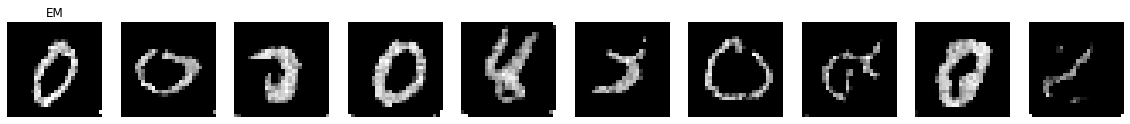

  0%|          | 0/500 [00:00<?, ?it/s]

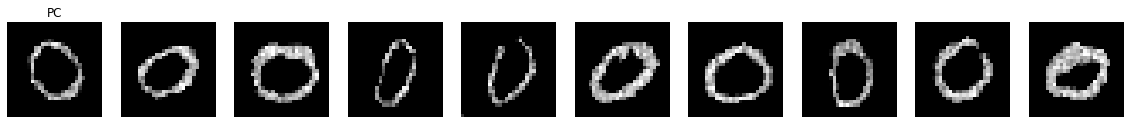

Number of ODE function evaluations: 470


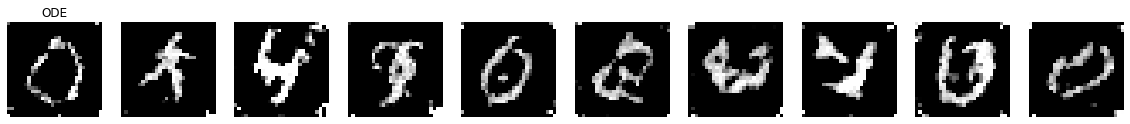

  0%|          | 0/500 [00:00<?, ?it/s]

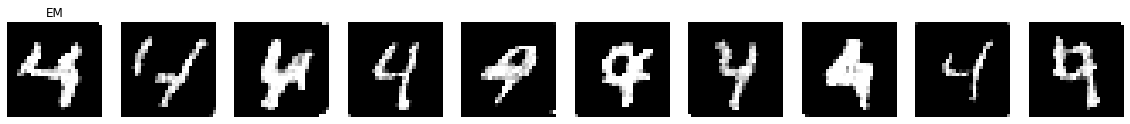

  0%|          | 0/500 [00:00<?, ?it/s]

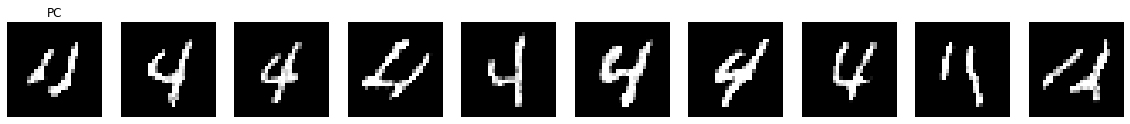

Number of ODE function evaluations: 494


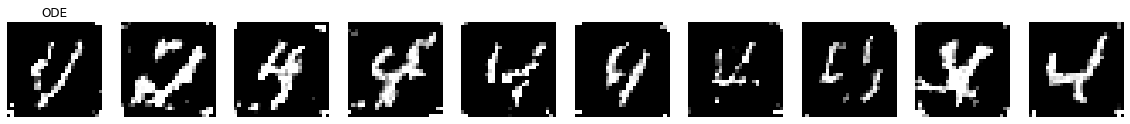

  0%|          | 0/500 [00:00<?, ?it/s]

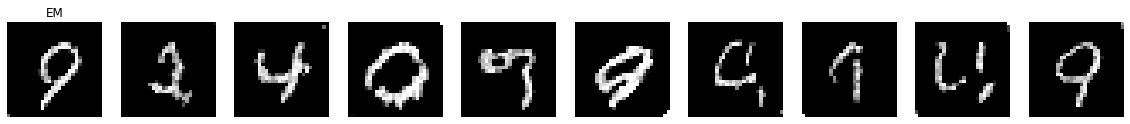

  0%|          | 0/500 [00:00<?, ?it/s]

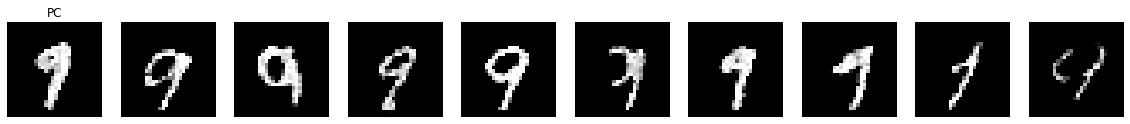

Number of ODE function evaluations: 488


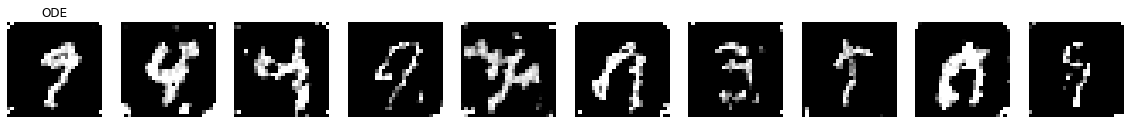

In [16]:
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    for sampler in ("em", "pc", "ode"):
        samples = generate_samples(model, sde, class_to_sample, sampler=sampler, t_limit=t_limit)
        plot_digits(torch.clamp(samples, 0, 1).cpu(), title=sampler.upper())